## Train Infection Classifier

In this lesson we will train a neural network for classifying cells into infected / non infected. We will use a [ResNet](https://arxiv.org/abs/1512.03385) for this task. ResNets are the most commonly used architecture for image classification task.

Here, we will choose the following three channels as input for the ResNet:
- The `marker` channel that indicates the presence of viral RNA in a cell. This is the most important signal for determining if a cell is infected or not.
- The `nucleus` channel, so that the position of the cell nucleus is also given to the network.
- The `cell-mask` channel, which corresponds to the binary mask for the current cell.

We will go through the steps to create this input for the network and then to train it now.

In [ ]:
# General imports.

import itertools
import json
import os
import sys
import time
from glob import glob

import imageio.v3 as imageio
import matplotlib.pyplot as plt
import napari
import numpy as np

sys.path.append("..")
import utils

In [ ]:
# This function will download and unpack the data and do some further data preparation.
# It will only be executed if the data has not been downloaded yet.
data_dir = "../data"
if os.path.exists(data_dir):
    print("The data is downloaded already.")
else:
    utils.prepare_data(data_dir)

In [ ]:
# The data has been downloaded and separated into folders for the train, validation and test split already.
# We first create a dictionary with the location of the three different split folders.
data_dirs = {
    "train": os.path.join(data_dir, "train"),
    "val": os.path.join(data_dir, "val"),
    "test": os.path.join(data_dir, "test")
}

# And check the content for one of the samples.
# After the print you should see the images (marker, nuclei, serum), labels (cells and nuclei) as well as a json file.
train_sample0 = os.path.join(data_dirs["train"], "gt_image_000")
print(os.listdir(train_sample0))

### 1. Inspect Training Data

We check the training data for one of the images. Our goal is to classify the cells into being infected / non-infected.
To this end we cut out small images containing only the image data around a given cell.
We then us three channels as input to the neural network for classification:
- The `marker` channel, which indicates the infection.
- The `nucleus` channel, to locate the signal w.r.t. the nucleus.
- The `cell-mask`, which corresponds to the binary mask for the given cell. We will create it from the cell segmentation. It is added to delineate the cell within the local image.

We will also remove the signal that is not within the cell, in order to avoid areas outside of the cell affecting the classification result.
Note that We DO NOT use the `serum` channel as input to the model.

All the information for extracting these labels is present already, we now check it for the first training sample.

In [ ]:
# The file paths for the images of the first training sample.
marker_path = os.path.join(train_sample0, "gt_image_000_marker_image.tif")
nucleus_path = os.path.join(train_sample0, "gt_image_000_nucleus_image.tif")
cell_segmentation_path = os.path.join(train_sample0, "gt_image_000_cell_labels.tif")

In [ ]:
# Load the image and segmentation data for the first sample.
marker = imageio.imread(marker_path)
nuclei = imageio.imread(nucleus_path)
cells = imageio.imread(cell_segmentation_path)

In [ ]:
# Load the classification data from the json file.
# This file was created in the data preparation script and it already contains the information needed
# for classifying the cells: it holds a list which contains for each cell the following three attributes:
# - cell_id: the pixel value for this cell in the cell segmentation.
# - infected_label: the classification label for this cell. This label has 4 possible values:
#  - 0: the cell has not been labeled
#  - 1: the cell is infected
#  - 2: the cell is not infected
#  - 3: the infection status of the cell is unclear
# -  bbox: the coordinates for the local window in the image that contains the cell
#    (bbox is short for bounding_box)
classification_label_path = os.path.join(train_sample0, "labels.json")
with open(classification_label_path, "r") as f:
    classification_label_data = json.load(f)

In [ ]:
# Let's look at the content of the classification label data:
classification_label_data
# You should see a list with values for each cell as described above.

In [ ]:
# We now want to visualize the classification data together with the image data
# to verify that we understand the labels and their meaning correctly.

# We will use napari for this visualization and so we have to process the
# classification data a bit to bring it in a suitable format for napari.
# For this we extract both the classification labels and the bounding boxes.
classification_labels = []
bounding_boxes = []
for cell_data in classification_label_data["cells"]:
    bbox = cell_data["bbox"]
    # We skip cells for which we don't have bounding box information.
    if bbox is None:
        continue
    classification_labels.append(cell_data["infected_label"])
    # We need to change the bounding box format to display them correctly in napari.
    bounding_boxes.append([bbox[:2], bbox[2:]])

In [ ]:
# We now visualize the image data and classification labels with napari:
viewer = napari.Viewer()
# Add the image data: the marker channel (red channel) and nucleus channel (blue channel).
viewer.add_image(marker, colormap="red", blending="additive")
viewer.add_image(nuclei, colormap="blue", blending="additive")
# Add another layer for visualizing the classification labels:
# we make use of the napari shape layer for this, which can be used to overlay windows on top of the image.
# Here, we use the 'bounding_boxes' list we just extracted as coordinates for this windows.
# So each window will show the cutout for one of the cells.
# We set the outline color of the window depending on the classification label and set it to 
# red for infected cells, blue for non-infected cells and grey for cells with unclear infection status.
viewer.add_shapes(
    bounding_boxes, shape_type="rectangle", face_color="transparent", edge_width=2,
    properties={"label": classification_labels},
    edge_color="label", edge_color_cycle=["red", "blue", "grey"],
)

After running the code above napari will open. With some adjustment of the contrast limits for nuclei and marker channel you should then see that the cells contained in the red ouline have a high intensity and patterned expression in the marker channel, whereas the cells in the blue outline have a low signal. Similar to the screenshot below.

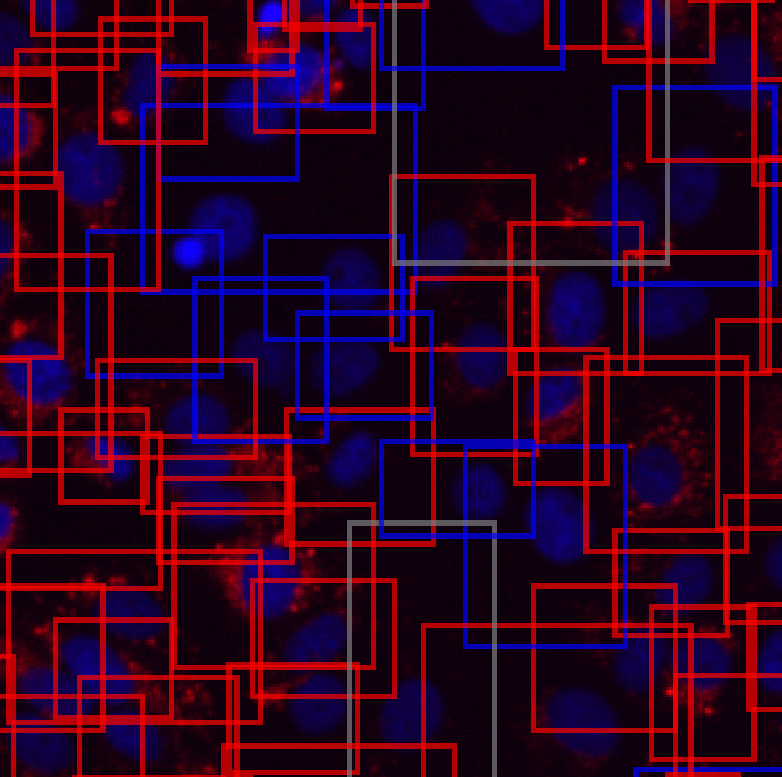

### 2. Prepare the Data for Training

We now have to prepare this training data so that it can be used in PyTorch to train a neural network for classifying the cells.
For this step we first cut out the small window around each cell as an extra image. We do this for each image and store the small cell images for the training, validation and test set separately.

In [ ]:
# Here we define the function that cuts out the small images centered around the cells for one image.

# This is a helper function for normalizing an image to the range [0, 1].
# Data normalization is important when training neural networks for image data
# to make sure all the inputs are in the same data range.
def normalize(image):
    image = image.astype("float32")
    image -= image.min()
    image /= (image.max() + 1e-7)
    return image


# This is the main function for extracting the small images.
# We give it the path to the folder containing the data for a sample as input.
# Remember that this contains the images, segmentations and classification data
# in individual files for each sample. We have explored some of this data above.
def extract_images_and_labels(sample_folder):
    # First we load the classififcation data from the json file.
    classification_label_path = os.path.join(sample_folder, "labels.json")
    with open(classification_label_path, "r") as f:
        classification_data = json.load(f)

    # Then we create the filepaths for the image and segmentation data we will load. 
    sample_name = os.path.basename(sample_folder)  # We can derive the sample name from the foldername.
    marker_path = os.path.join(sample_folder, f"{sample_name}_marker_image.tif")
    nucleus_path = os.path.join(sample_folder, f"{sample_name}_nucleus_image.tif")
    cell_segmentation_path = os.path.join(sample_folder, f"{sample_name}_cell_labels.tif")

    # And load the two images (marker and nuclei) and the cell segmentation.
    # We normalize the marker and nucleus image so that their data range is in [0, 1].
    marker = normalize(imageio.imread(marker_path))
    nuclei = normalize(imageio.imread(nucleus_path))
    # Note that we must not normalize the segmentation!
    cells = imageio.imread(cell_segmentation_path)

    # Now we iterate over the classification data and cut out the small
    # image with marker, nucleus channel and binary mask from the window containing the cell. 
    images, labels = [], []
    for cell_data in classification_data["cells"]:
        label, bbox = cell_data["infected_label"], cell_data["bbox"]
        # We only consider data which has either the classification label 1 (cell is infected)
        # or label 2 (cell is not infected). We skip cells with a different label.
        if label not in (1, 2):
            continue

        # Convert the bounding box to a format that can be used to index the image.
        bbox = np.s_[bbox[0]:bbox[2], bbox[1]: bbox[3]]

        # Extract the small image for the marker and nucleus.
        marker_im = marker[bbox]
        nuc_im = nuclei[bbox]
        # Extract the binary mask for the current cell. 
        # We create the mask by setting the pixels which have the id of our cell to 1
        # (which is done by the '==' below.)
        mask = cells[bbox] == cell_data["cell_id"]

        # Now we black out all data that is not in the cell mask. We can do this
        # by indexing the image with the inverse of the mask (`~mask`) and setting all
        # the values in the inverse mask to zero.
        # This step is taken to ignore the data from the surrounding of the cell, but not
        # directly in the cell.
        marker_im[~mask] = 0
        nuc_im[~mask] = 0

        # Now we combine the marker, nucleus and binary mask into an image with three channels
        # and then append the small image and the corresponding label to the list of images and labels.
        image = np.stack([marker_im, nuc_im, mask.astype("float32")])
        images.append(image)
        labels.append(label)

    # We check that we have the same number of small images and labels and then return them.
    assert len(images) == len(labels)
    return images, labels

In [ ]:
# This function applies the data extraction function we just defined to all samples
# for a split (training, validation or test) and extracts all the corresponding small images
# and classification labels.
def prepare_split(split):
    # Get all the folders for the samples of this split.
    split_folder = data_dirs[split]
    samples = glob(os.path.join(split_folder, "gt*"))
    # Iterate over all the samples and extract the images and labels from them.
    images, labels = [], []
    for sample in samples:
        sample_images, sample_labels = extract_images_and_labels(sample)
        images.extend(sample_images)
        labels.extend(sample_labels)
    return images, labels

In [ ]:
# Now we apply the functions for the training, validation and test split
# and check how many samples we have for each split.

train_images, train_labels = prepare_split("train")
print("We have", len(train_images), "training samples.")

In [ ]:
val_images, val_labels = prepare_split("val")
print("We have", len(val_images), "validation samples")

In [ ]:
test_images, test_labels = prepare_split("test")
print("We have", len(test_images), "test samples")

In [ ]:
# Finally, we visualize some of the extracted images with napari.
# For this we first randomly select a number of samples from the training data.
n_samples_for_visualization = 25
indices_for_visualization = np.random.choice(
    len(train_images), n_samples_for_visualization, replace=False
)  # This function randomly selects indices.

# Now we add those images to napari.
viewer = napari.Viewer()
for index in indices_for_visualization:
    image, label = train_images[index], train_labels[index]
    # Change the image name depending on its infection status.
    label_name = "infected" if label == 1 else "not-infected"
    
    # We modify the image a bit to visualize it correctly in napari.
    image_for_visualization = image.transpose((1, 2, 0))
    image_for_visualization[..., -1] = image_for_visualization[..., 1]
    image_for_visualization[..., 1] = 0
    
    viewer.add_image(image_for_visualization, name=f"sample{index}-{label_name}")

# This enables a grid-view in napari, so that you will see all images side by side.
viewer.grid.enabled = True

**TODO**: there are quite a lot artefacts in the segmentation. Filter them out or improve the segmentation?
Then explain what we see here.

### 3. Train the Infection Classifier

We now have the data in a format we can use to train a network with classification with PyTorch.
For training with PyTorch we need to define a few more steps and functions that convert the data to 
the PyTorch data formats and then to define the training procedure.

If you have not used PyTorch before you can find a quick introduction to how it works [here](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html).

In [ ]:
# Import the PyTorch functionality we need.
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models.resnet import resnet18

# Additional imports for evaluation and image transformations.
from sklearn import metrics
from skimage.transform import resize

In [ ]:
# We first check if we have access to a GPU.
# The model training will be much faster if we can use a GPU.
if torch.cuda.is_available():
    print("GPU is available")
    device = torch.device("cuda")
else:
    print("GPU is NOT available. The training will be very slow!")
    device = torch.device("cpu")

In [ ]:
# In order to use the image data in PyTorch we need to bring all small images to a common size.
# This will enable combining multiple images in one batch and is essential for efficient training (more details below).
# So as a first step we determine the average size of all images in our training and validation set.
shapes = np.stack([np.array(image.shape) for image in (train_images + val_images)])
mean_shape = np.mean(shapes, axis=0)
print("Mean image shape:", mean_shape)

You should see that the average image shape is roughly 52 x 52 pixels. We choose the closest multiple of 16 as common shape, which is 64 x 64.

In [ ]:
# To provide the data for training we need to create a PyTorch Dataset.
# Datasets provide a single example (= small image + label) for training.
# They can also be used to process the data further. Here, we resize the images
# to the common shape within the dataset.

# You can find more information on datasets here:
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

# To create a dataset for our task we create a class that inherits
# from the PyTorch dataset.
class CustomDataset(Dataset):
    # Here we define the data for creating the dataset:
    # The small images for this dataset, the labels and the size for reshaping the images.
    def __init__(self, images, labels, target_size):
        self.images = images
        self.labels = labels
        self.target_size = target_size

    # A dataset needs a __len__ method that returns how many samples are in the dataset.
    # Here, the number of samples corresponds to the number of small images.
    def __len__(self):
        return len(self.images)

    # The __getitem__ method returns the image data and labels for a given sample index.
    def __getitem__(self, index):
        # Load the image data and label for this sample index.
        image = self.images[index]

        # We have to subtract 1 from the labels, because PyTorch expects the classification labels
        # to start from 0. Hence we change the labels as follows:
        # 1 -> 0 = cell is infected
        # 2 -> 1 = cell is not infected.
        label = self.labels[index] - 1
        
        # Resize the image to the common size.
        # TODO: Should we make a note that there are different options for how this can be done?
        resized_image = resize(image, self.target_size, preserve_range=True)
        return resized_image, label

In [ ]:
# Now we create the datasets for the training and validation set.

# We also need to define the common shape for the images here.
# Remember that we have determined a good image shape as 64 x 64.
# The 3 is for the number of channels, which is the same for each image.
image_shape = (3, 64, 64)

train_dataset = CustomDataset(train_images, train_labels, target_size=image_shape)
val_dataset = CustomDataset(val_images, val_labels, target_size=image_shape)

In [ ]:
# We now need to create the dataloaders that use the datasets we have just defined in order
# to provide the training data for PyTorch. Dataloaders do the following:
# - They choose indices for a set number of samples ("batch_size") that will be used for each training iteration.
# - Then they fetch the corresponding samples from the dataset.
# - They convert the image and label data to the correct datatype for PyTorch.
# - Finally, they combine the image data into a single input, by stacking all the small images.
#   And do the same for the labels.
#    - This is also the reason why we need to bring all images to the same shape, otherwise they could
#      not be combined into a single input.

# This is the number of samples that will be used for one iteration.
# This means the data loader will return 32 images and labels, combined to a single input / label vector.
batch_size = 32

# Number of workers for parallel loading (This is a detail you can ignore for now.)
num_workers = 4 if torch.cuda.is_available() else 1

# Create the dataloaders for training and validation.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [ ]:
# Let's check one sample from the training loader and see that this matches what we just discussed.
# x is the input data (images for one batch) and y the label data (labels for one batch).
x, y = next(iter(train_loader))

# Let's print the shapes.
print("Input shape:", x.shape)
print("Label shape:", y.shape)
print("Label values:", torch.unique(y))

# You should see that these shapes match what we discussed above:
# - x contains 32 small images, all resized to the common image shape
# - y contains 32 labels (each is either 0 or 1)

**TODO**: I have not added explanations from here on out. These should still be added.

In [ ]:
# This function trains the given model for one epoch using the provided data loader
def train_epoch(model, loader, loss_function, optimizer):

    # Set the model to training mode
    model.train()

    # Array to store training loss values
    loss_values = []

    # Iterate through batches in the data loader
    for x, y in loader:
        # Move data to the device (e.g., GPU)
        x, y = x.to(device), y.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass: compute predictions
        prediction = model(x)

        # Compute the loss
        loss = loss_function(prediction, y)

        # Backward pass: compute gradients
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Store the loss for the current batch
        loss_values.append(loss.item())

    # Return the list of training loss values for the epoch
    return loss_values

In [ ]:
# this function evaluates a PyTorch model on a given data loader
def evaluate_model(model, loader):
    # Set the model to evaluation mode
    model.eval()

    # Lists to store predictions and actual labels
    predictions, labels = [], []

    # Disable gradient computation during evaluation
    with torch.no_grad():
        # Iterate through batches in the data loader
        for x, y in loader:
            # Move data to the device (e.g., GPU)
            x, y = x.to(device), y.to(device)

            # Forward pass: compute predictions
            prediction = model(x)

            # Extract predicted labels
            _, prediction = torch.max(prediction, 1)

            # Extend lists with predicted and actual labels
            predictions.extend(prediction.cpu().numpy())
            labels.extend(y.cpu().numpy())

    # Compute evaluation metrics
    f1 = metrics.f1_score(labels, predictions)
    precision = metrics.precision_score(labels, predictions)
    recall = metrics.recall_score(labels, predictions)
    confusion_matrix = metrics.confusion_matrix(labels, predictions)

    # Return evaluation metrics
    return f1, precision, recall, confusion_matrix

In [ ]:
# Define model, optimizer and loss function.
model = resnet18(num_classes=2)
model.to(device)

# Define the learning rate and chose the optimizer: adam 
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# The loss function.
loss_function = torch.nn.CrossEntropyLoss()

In [ ]:
train_loss_history = []
f1_history = []
precision_history = []
recall_history = []
confusion_matrix_history = []

In [ ]:
num_epochs = 15

for epoch in range(num_epochs):
    t_start = time.time()
    train_losses = train_epoch(model, train_loader, loss_function, optimizer)
    f1, precision, recall, confusion_matrix = evaluate_model(model, val_loader)

    train_loss_history.extend(train_losses)
    f1_history.append(f1)
    precision_history.append(precision)
    recall_history.append(recall)
    confusion_matrix_history.append(confusion_matrix)

    avg_loss = np.mean(train_losses)
    t_epoch = time.time() - t_start
    print("Epoch", epoch, "training loss:", avg_loss, "validation f1-score:", f1, "ran for", t_epoch, "s")

Now we can plot the loss and metric values during training. We have implemented the functions in the cell below. You don't need to look at the details of this since it's just plotting curves, which takes quite a lot of code.

In [ ]:
# Functions to plot the metrics
def simple_exponential_smoothing(series, alpha):
    forecast = [series[0]]  # Initial forecast is the first observation in the series

    for t in range(1, len(series)):
        forecast_t = alpha * series[t] + (1 - alpha) * forecast[t - 1]
        forecast.append(forecast_t)

    return forecast
    
def plot_confusion_matrix(conf_matrix):
    classes = np.arange(conf_matrix.shape[0])
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    fmt = 'd'
    thresh = conf_matrix.max() / 2.

    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, format(conf_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

def plot_training_curves():
    iterations = range(1, len(train_loss_history) + 1)
    epochs = range(1, len(f1_history) + 1)

    # Smooth the training curve
    alpha = 0.01
    smooth_train_loss_history = simple_exponential_smoothing(train_loss_history, alpha)
    # Plotting loss
    plt.figure(figsize=(16, 9))
    plt.subplot(2, 3, 1)
    plt.plot(iterations, smooth_train_loss_history, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting F1-Score
    plt.subplot(2, 3, 2)
    plt.plot(epochs, f1_history, label='F1-Score')
    plt.title('Validation F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.legend()

    # Plotting precision
    plt.subplot(2, 3, 3)
    plt.plot(epochs, precision_history, label='Precision')
    plt.title('Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    # Plotting recall
    plt.subplot(2, 3, 4)
    plt.plot(epochs, recall_history, label='Recall')
    plt.title('Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    # Plotting confusion matrix
    plt.subplot(2, 3, 6)
    conf_matrix = confusion_matrix_history[-1]
    plot_confusion_matrix(conf_matrix)

    plt.tight_layout()
    plt.show()

In [ ]:
plot_training_curves()

#### What do you see when you look at the plots? 
- is there anythin noticeable?
- what might be the cause?
>

In [ ]:
# What is important here:  
#    - We see that the model starts to overfit rather soon.  
#    - We see problems due to class imbalance.  


### 4. Apply the classifier to the test set

By applying the classifier to the test data set, we can evaluate the model's predictive capabilites on unseen data.

In [ ]:
test_dataset = CustomDataset(test_images, test_labels, target_size=image_shape)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [ ]:
# print the scores and plot the confusion matrix
f1_score, precision, recall, confusion_matrix = evaluate_model(model, test_loader)
print("F1-Score:", f1_score)
print("Precision:", precision)
print("Recall:", recall)

plt.figure()
plot_confusion_matrix(confusion_matrix)
plt.show()

## Exercises

**TODO:** List of ideas for exercises, we should formulate this further.

- Dealing with class imbalance. (Using a weighted loss)
- Changing the learning rate and observe the effects.
- Try a ResNet34.

**Advanced Exercises:**

These would need more changes in the code

- Build your own classification network.
- Implement early stopping.
- Add data augmentations.